# Small sample statistics

Szymon Talaga | 30 March 2020

![ZIP logo](zip.png)

<hr>

In [1]:
install.packages(c("latex2exp"))
# Packages that we will need
library(tidyverse)    # read in core tidyverse packages at once
library(latex2exp)    # for easy math on plots

# Set default theme for ggplot2
theme_set(theme_bw())

Installing package into ‘/home/sztal/R/x86_64-pc-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In this notebook we review and implement in `R` the methods discussed in chapter 7.

## Assessing normality

Here we show how we can draw QQ plots and run Kolmogorv-Smirnov and Shapiro-Wilk tests.

We start by examining QQ plots for three cases. 
For quick QQ plotting we will use base implementation, but later on also the GGPlot approach will be discussed.

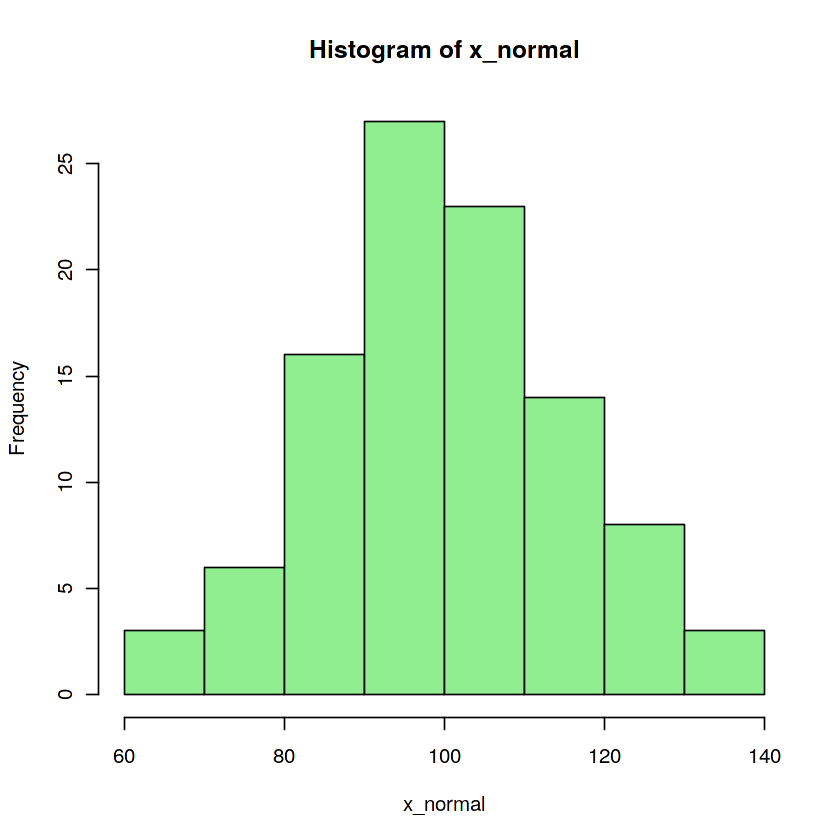

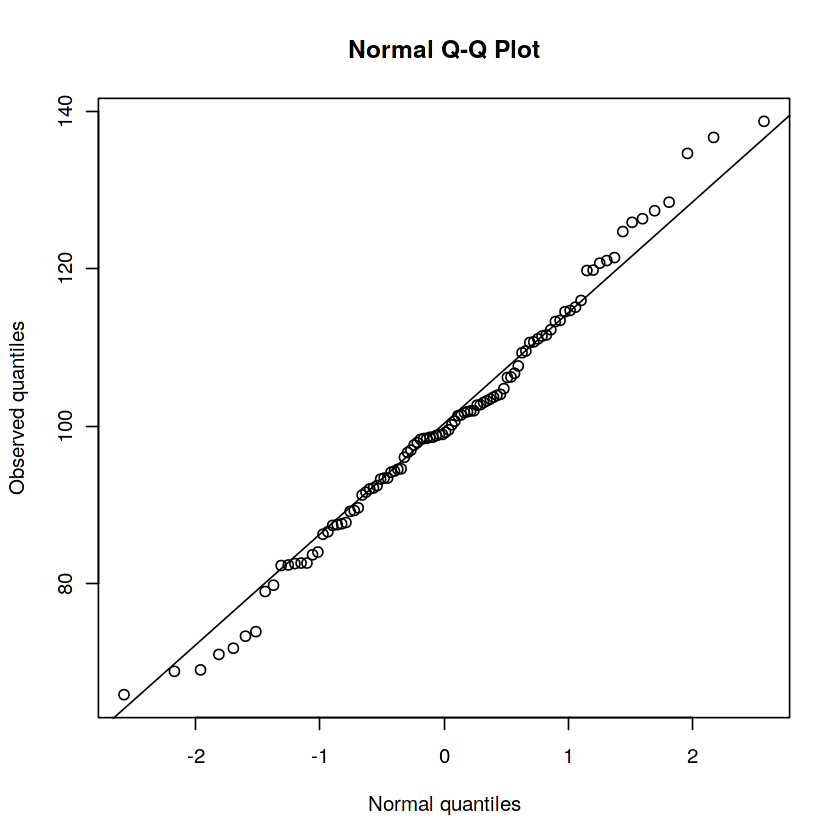

In [2]:
set.seed(100)
###################################
### Normal distribution (n = 100)
###################################
x_normal <- rnorm(100, mean = 100, sd = 15)

hist(x_normal, col = "lightgreen")
qqnorm(x_normal, xlab = "Normal quantiles", ylab = "Observed quantiles")
qqline(x_normal)

Clearly, agreement with normal distribution is very good. This is not surprising since we know our data is normal.

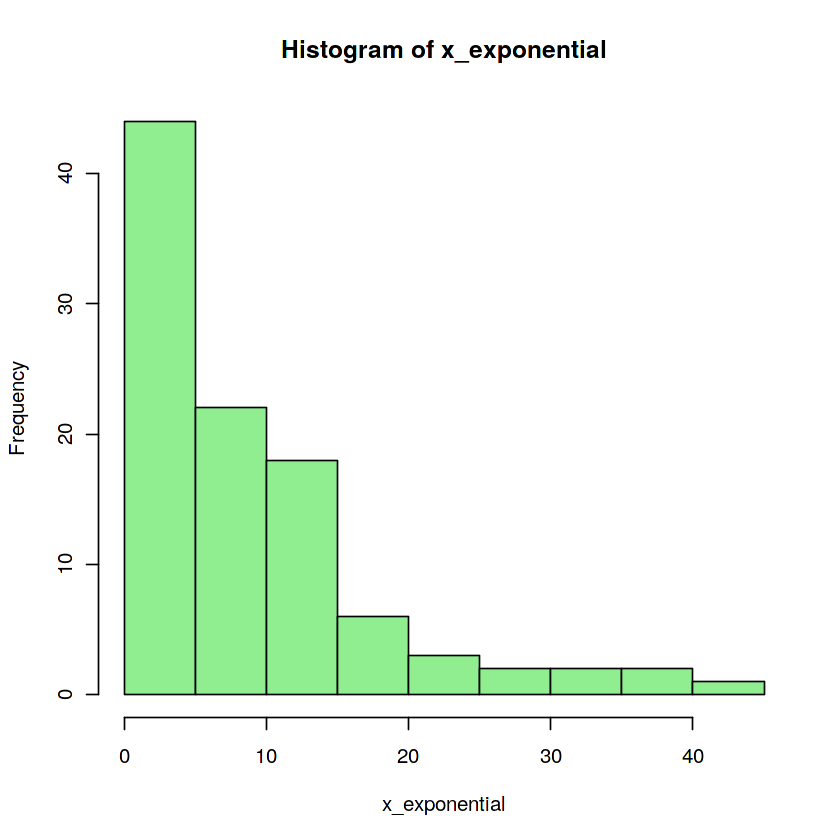

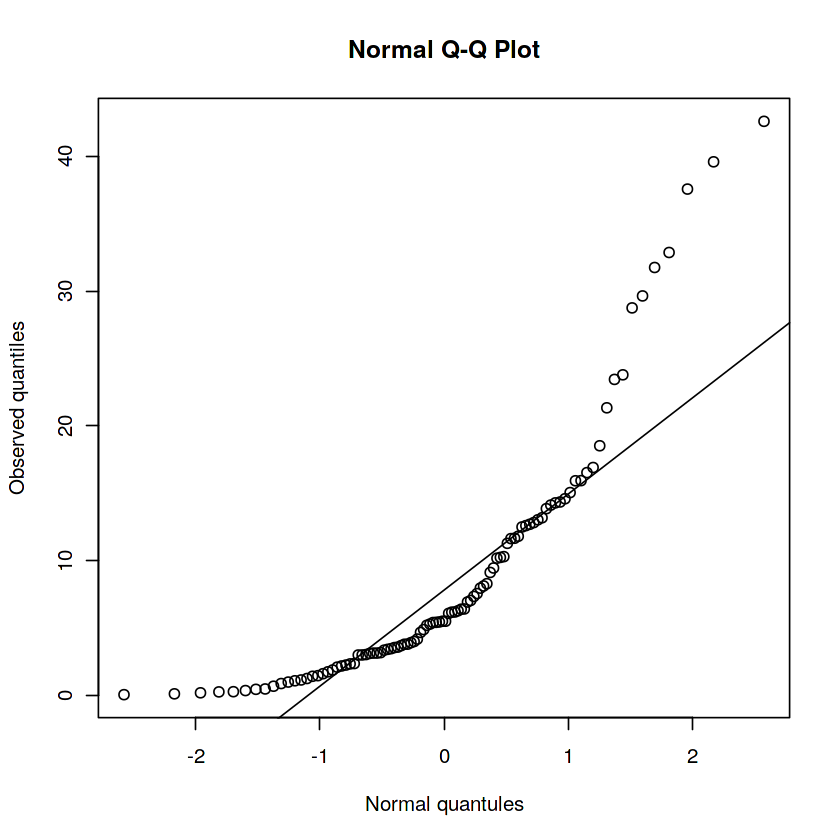

In [3]:
set.seed(101)
### Exponential distribution (n = 100)
x_exponential <- rexp(100, rate = 1/10)

hist(x_exponential, col = "lightgreen")
qqnorm(x_exponential, xlab = "Normal quantules", ylab = "Observed quantiles")
qqline(x_exponential)

Here we see an important kind of a pattern on QQ plot, so it is crucial we understand it.
Observed quantiles on the left (low values) are higher than expected. This means that the left tail
is shrinked in comparison to a normal distribution. This makes sense, since we know that
exponential distribution is bounded from below by $0$.

On the other hand observed quantiles on the right (high values) are also higher than expected.
In this case this means that the right tail is stretched (longer) in comparison to a normal distribution.
In other words, high values are much more frequent than in a normal distribution.

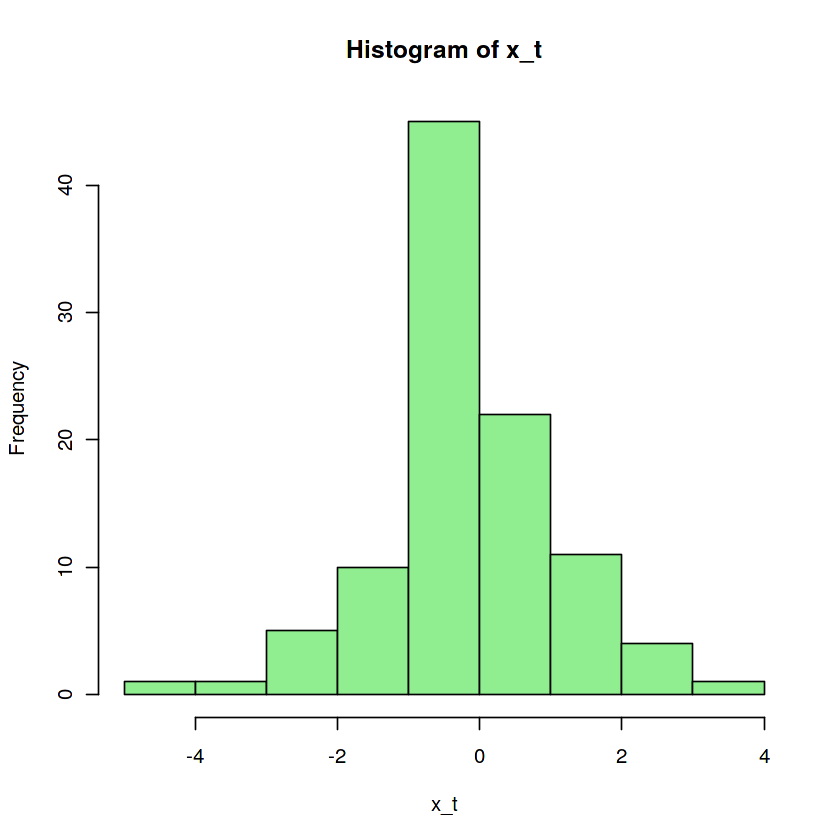

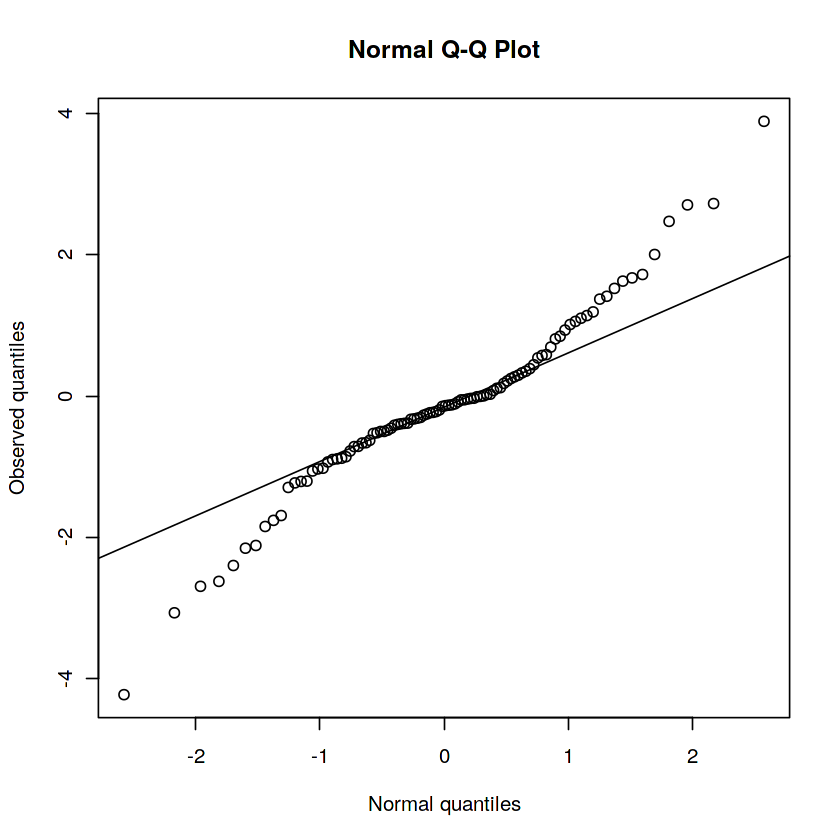

In [4]:
set.seed(104)
##############################################
### t distribution with 3 degrees of freedom
#############################################
# It is more or less like normal, but has much fatter, longer tails.
x_t <- rt(100, df = 3)

hist(x_t, col = "lightgreen")
qqnorm(x_t, xlab = "Normal quantiles", ylab = "Observed quantiles")
qqline(x_t)

In this case the left tail (low values) has lower quantiles than expected
which means that it is longer than in the corresponding normal distribution
with the same mean and variance.

The right tail has higher quantiles than expected which also means
that it is longer than in the normal distribution.

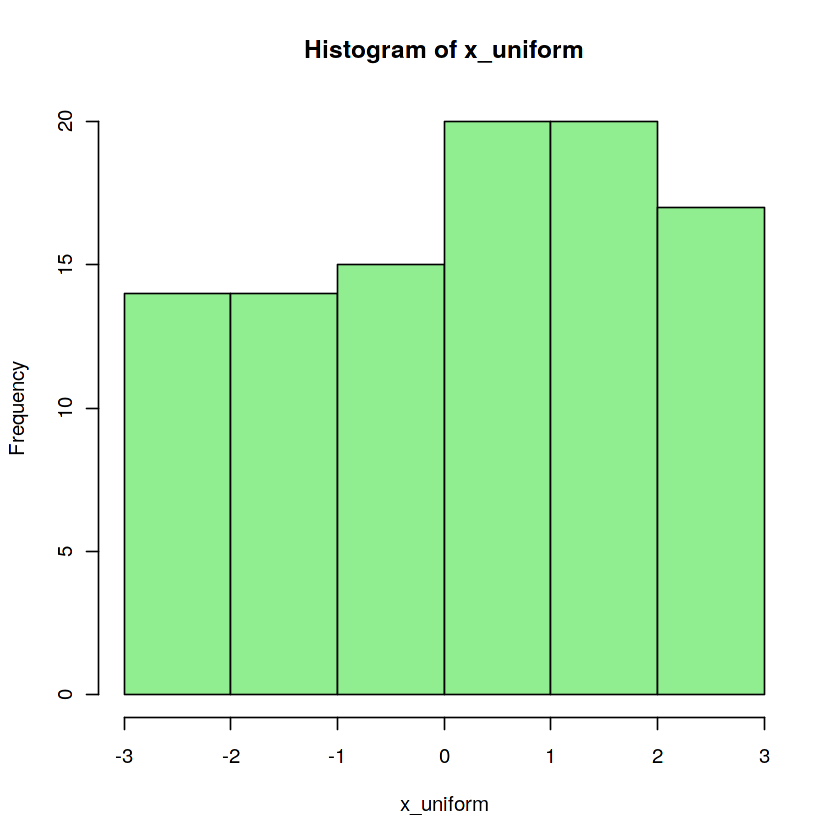

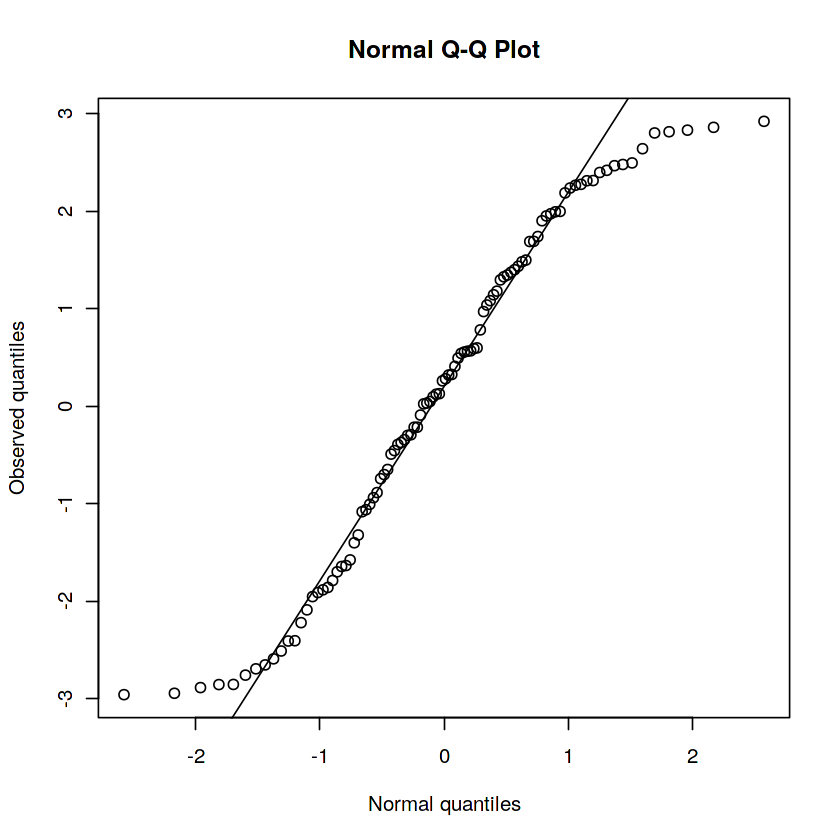

In [5]:
set.seed(10101)
##################################
### Uniform in the range -3 to 3
##################################
x_uniform <- runif(100, -3, 3)

hist(x_uniform, col = "lightgreen")
qqnorm(x_uniform, xlab = "Normal quantiles", ylab = "Observed quantiles")
qqline(x_uniform)

Here we see a pattern characteristic for a distribution which is truncated.
Note how observed quantiles flattens out at $-3$ and $3$.

Now we will draw a more complex plot with histograms and QQ plots for three different distributions
using GGPlot. Then we will use this data to run Kolmogorov-Smirnov and Shapiro-Wilk tests and learn how they work in practice.

In [11]:
set.seed(1010)
### Number of data points
N <- 100
### Dataset
### `tibble` is enhanced data.frame class provided by the tidyverse suite of packages.
### It works like stadard `data.frame` but prints in a nicer way and have some other useful features.
df <- tibble(
    normal = rnorm(N, mean = 0, sd = 1),
    t_df3  = rt(N, df = 3),
    t_df10 = rt(N, df = 10),
    t_df20 = rt(N, df = 20)
)

head(df)

normal,t_df3,t_df10,t_df20
<dbl>,<dbl>,<dbl>,<dbl>
0.1315409,-0.53525545,0.36845670,-0.1508402
-0.8979099,-0.05159170,-1.04801393,-1.9094668
1.3519446,-0.08819596,-0.08171652,-0.3622817
0.4200747,0.61288952,-0.47575090,0.2121477
-0.2884597,-4.48600691,-1.96401305,0.1712393
1.3645614,0.87172100,1.07366934,2.2823064


To draw the plot easily we will reshape our data and cast it to the long format.

In [12]:
df_long <- df %>%
    pivot_longer(c(normal, t_df3, t_df10, t_df20))

head(df_long)

name,value
<chr>,<dbl>
normal,0.1315409
t_df3,-0.5352554
t_df10,0.3684567
t_df20,-0.1508402
normal,-0.8979099
t_df3,-0.0515917


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



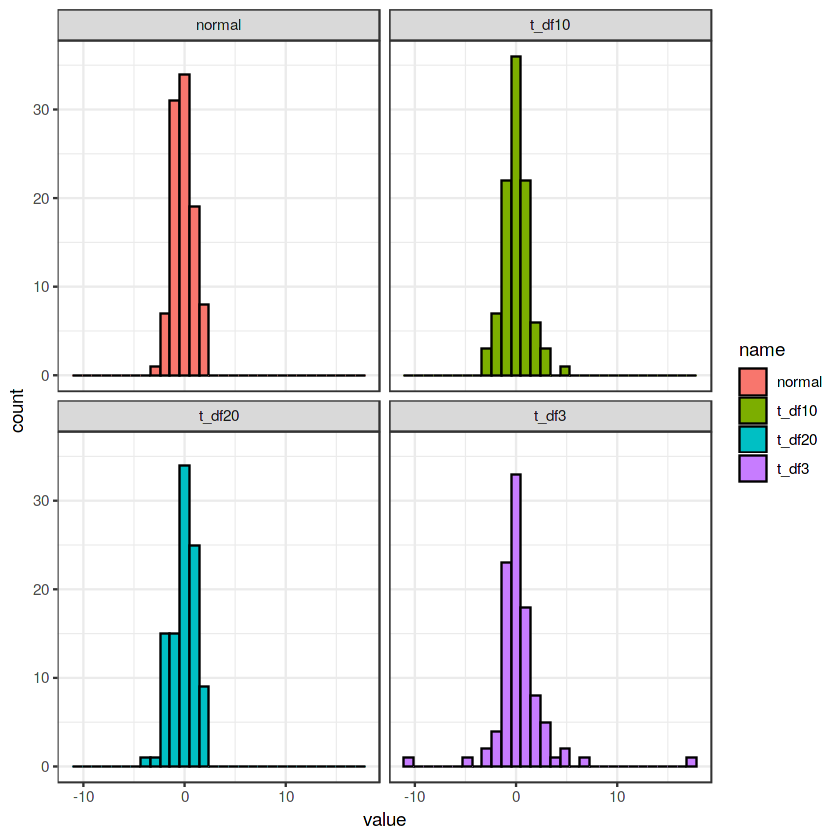

In [13]:
## HISTOGRAMS
df_long %>%
    ggplot(aes(x = value, fill = name)) +
    geom_histogram(color = "black") +
    facet_wrap(~name, ncol = 2, nrow = 2)

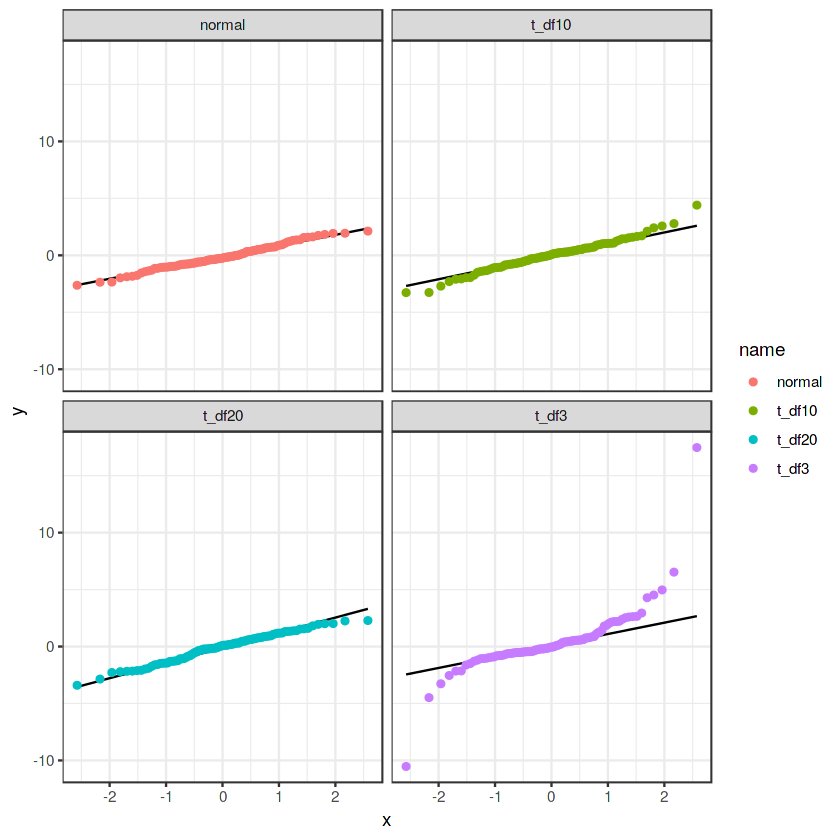

In [14]:
df_long %>%
    ggplot(aes(sample = value, color = name)) +
    geom_qq_line(color = "black") +
    geom_qq() +
    facet_wrap(~name)

Clearly, we see significant deviations only in the case of the $t$ distribution with $3$ degrees of freedom.

In [15]:
## KS test
## The second argument is the function
## implementing CDF of normal distribution

## KS test for t distribution with 3 degrees of freedom
ks.test(df$t_df3, pnorm)


	One-sample Kolmogorov-Smirnov test

data:  df$t_df3
D = 0.14381, p-value = 0.03197
alternative hypothesis: two-sided


In [16]:
## SW test for t distribution with 3 degrees of freedom
shapiro.test(df$t_df3)


	Shapiro-Wilk normality test

data:  df$t_df3
W = 0.69609, p-value = 4.377e-13


Interestingly, Shapiro-Wilk test is clearly much more powerful than Kolmogorov-Smirnov test
since it yielded significant results (for $t$ with $df = 3$ which is not normal) and KS test barely did so. It would not reject with $\alpha = 0.01$.

In [17]:
shapiro.test(df$t_df10)


	Shapiro-Wilk normality test

data:  df$t_df10
W = 0.98134, p-value = 0.1689


Let us now see what happens in larger samples.

In [20]:
set.seed(1012)
### Number of data points
N <- 2000
### Dataset
### `tibble` is enhanced data.frame class provided by the tidyverse suite of packages.
### It works like stadard `data.frame` but prints in a nicer way and have some other useful features.
df <- tibble(
    normal = rnorm(N, mean = 0, sd = 1),
    t_df3  = rt(N, df = 3),
    t_df10 = rt(N, df = 10),
    t_df20 = rt(N, df = 20)
)

df_long <- pivot_longer(df, c(normal, t_df3, t_df10, t_df20))

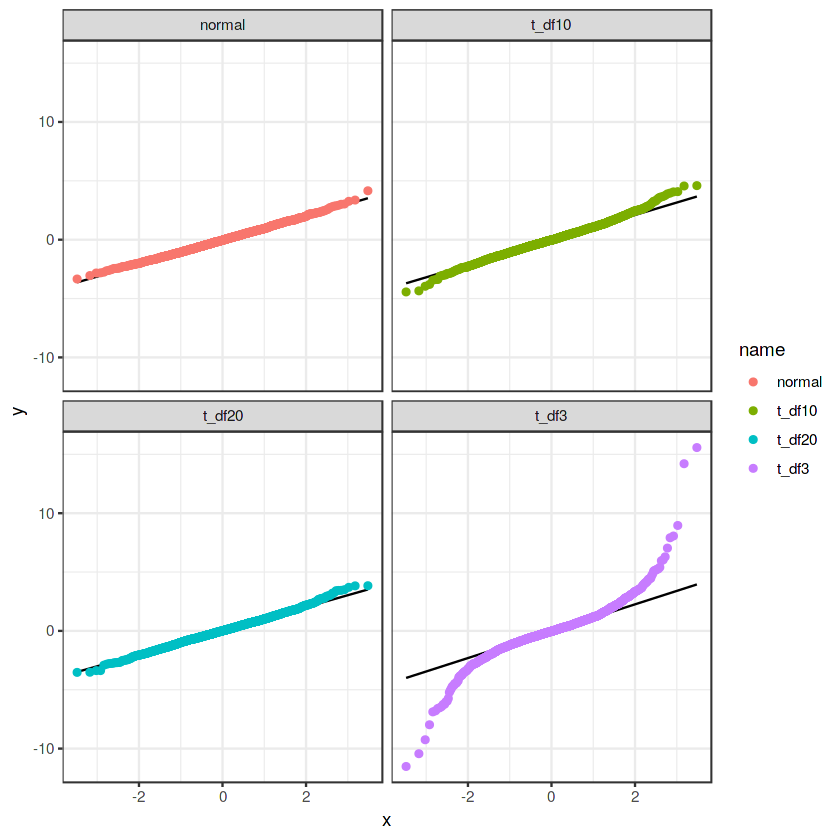

In [21]:
df_long %>%
    ggplot(aes(sample = value, color = name)) +
    geom_qq_line(color = "black") +
    geom_qq() +
    facet_wrap(~name)

In [22]:
shapiro.test(df$t_df20)


	Shapiro-Wilk normality test

data:  df$t_df20
W = 0.99767, p-value = 0.004836


This time we see that even for $t$ with $df = 20$ we get significant result
indicating lack of normality. Without looking at the QQ plot it could be tempting
to decide that the sample is not normal and choose for instance a non-parametric rank test
while the deviation is small enough that it is quite okay to use a $t$ test.

We show this with a simple numerical simulation in which we estimate the type I error
when running $t$ tests with data generated from a $t$ distribution with $20$ degrees of freedom.

In [ ]:
## NOTE ################
## THIS MAY TAKE A WHILE
########################
R <- 100000L

pvals <- vector(mode = "numeric", length = R)
for (i in 1:R) {
    data <- rt(nrow(df), df = 20)
    pval <- t.test(data)$p.value
    pvals[i] <- pval
}

mean(pvals <= .05)

## Normal sample variance

In this section we show the basic methods for statistical inference concerning sample variances.
We focus on the case of normal variances, but in the end we will show also a more general method.

### Single normal sample variance ($\chi^2$ distribution)

We will compute a $p$-value for hypothesis
$$
H_0: \sigma^2 = 10
$$
and construct a confidence interval.

In [23]:
set.seed(333)
## DATA
x <- rnorm(100, mean = 12, sd = sqrt(10))

In [24]:
sigma2_0 <- 10
s2 <- var(x)
df <- length(x) - 1

chisq_statistic <- df * s2 / sigma2_0
chisq_statistic

[1] 90.9361

In [25]:
pvalue <- 1 - pchisq(chisq_statistic, df = df)
pvalue

[1] 0.7059839

In [26]:
ci95_twosided <- df*s2 / c(qchisq(.975, df = df), qchisq(.025, df = df))
ci95_twosided

[1]  7.081038 12.395688

### Comparison of two normal sample variances ($F$ distribution)

Now we compare variances from two normal samples. 
First we do it by hand and then compare our results with
`var.test` function implemented in base `R`.

The null hypothesis is:
$$
H_0: \frac{\sigma^2_1}{\sigma^2_2} = 1
$$

In [27]:
x1 <- rnorm(100, mean = 100, sd = 15)
x2 <- rnorm(100, mean = 100, sd = 18)

null_ratio <- 1

s2_1 <- var(x1)
df1  <- length(x1) - 1

s2_2 <- var(x2)
df2  <- length(x2) - 1

F_statistic <- (s2_1 / s2_2) / null_ratio
F_statistic

[1] 0.7050206

In [28]:
## TWO-SIDED P-VALUE
pvalue <-  2 * pf(F_statistic, df1 = df1, df2 = df2)

In [29]:
## TWO-SIDED CONFIDENCE INTERVAL
ci95 <- F_statistic / c(qf(0.975, df1 = df1, df2 = df2), qf(0.025, df1 = df1, df2 = df2))
ci95

[1] 0.4743672 1.0478254

In [30]:
var.test(x1, x2)


	F test to compare two variances

data:  x1 and x2
F = 0.70502, num df = 99, denom df = 99, p-value = 0.08361
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.4743672 1.0478254
sample estimates:
ratio of variances 
         0.7050206 


## $t$ test

Here we show how to conduct $t$ tests in `R`.
We will save ourselves the trouble of doing this by hand,
since we already implemented a lot of $z$ tests this way
and the procedure is exactly the same, only the distribution
of the test statistic we use is different.

Instead, we will focus on `R` functions.

### One sample $t$ test

We will use the following hypotheses:
$$
H_0: \mu \leq 9
$$
$$
H_1: \mu > 9
$$

In [31]:
x <- rnorm(20, mean = 10, sd = 3)

t.test(x, mu = 9, alternative = "greater")


	One Sample t-test

data:  x
t = 3.0093, df = 19, p-value = 0.003606
alternative hypothesis: true mean is greater than 9
95 percent confidence interval:
 10.13127      Inf
sample estimates:
mean of x 
 11.65932 


### Two samples (paired)

We will test the null:
$$
H_0: \mu_1 = \mu_2
$$
And use $\alpha = 0.01$.

In [32]:
x1 <- rnorm(15, mean = 10, sd = 3)
x2 <- rnorm(15, mean = 12, sd = 3)

## SIGNIFICANCE LEVEL
alpha <- 0.01

##DIFFERENCES
diff <- x2 - x1

t.test(diff, conf.level = 1 - alpha)


	One Sample t-test

data:  diff
t = 4.3417, df = 14, p-value = 0.0006767
alternative hypothesis: true mean is not equal to 0
99 percent confidence interval:
 1.179942 6.326859
sample estimates:
mean of x 
 3.753401 


In [33]:
## ALTERNATIVE APPROACH
t.test(x2, x1, paired = TRUE, conf.level = 1 - alpha)


	Paired t-test

data:  x2 and x1
t = 4.3417, df = 14, p-value = 0.0006767
alternative hypothesis: true difference in means is not equal to 0
99 percent confidence interval:
 1.179942 6.326859
sample estimates:
mean of the differences 
               3.753401 


### Two samples (independent)

We will test the null:
$$
H_0: \mu_1 = \mu_2
$$
And use $\alpha = 0.05$ (default value in `R`).

We will use simulated samples with different variances
and compare results with and without the Welsch-Satterthwaite
correction.

In [34]:
set.seed(44)

x1 <- rnorm(15, mean = 100, sd = 15)
x2 <- rnorm(15, mean = 107, sd = 25)

t.test(x1, x2, var.equal = TRUE) ## by default var.equal = FALSE


	Two Sample t-test

data:  x1 and x2
t = -2.2023, df = 28, p-value = 0.03605
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -39.011670  -1.412059
sample estimates:
mean of x mean of y 
 92.71985 112.93172 


In [35]:
t.test(x1, x2, var.equal = FALSE)


	Welch Two Sample t-test

data:  x1 and x2
t = -2.2023, df = 17.589, p-value = 0.04125
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -39.5260187  -0.8977104
sample estimates:
mean of x mean of y 
 92.71985 112.93172 


The results are similar, but note that the $p$-value without the correction is lower.
This is due to the fact that corrected degrees of freedom are lower.
Therefore, without the correction we inflate the type I error rate.

### $t$ test as $z$ test

Here we will convince ourselves that $t$ test functions can be used in lieu of $z$ test functions
in large samples. This is useful, because $z$ tests are usually not implemented in statistical packages.

We will study the distribution of sample mean of variables that are ''normalish'', but not exactly.
In particular, they will be slightly right-skewed and bounded from below by$0$. 
A very typical scenario in real world data analysis.

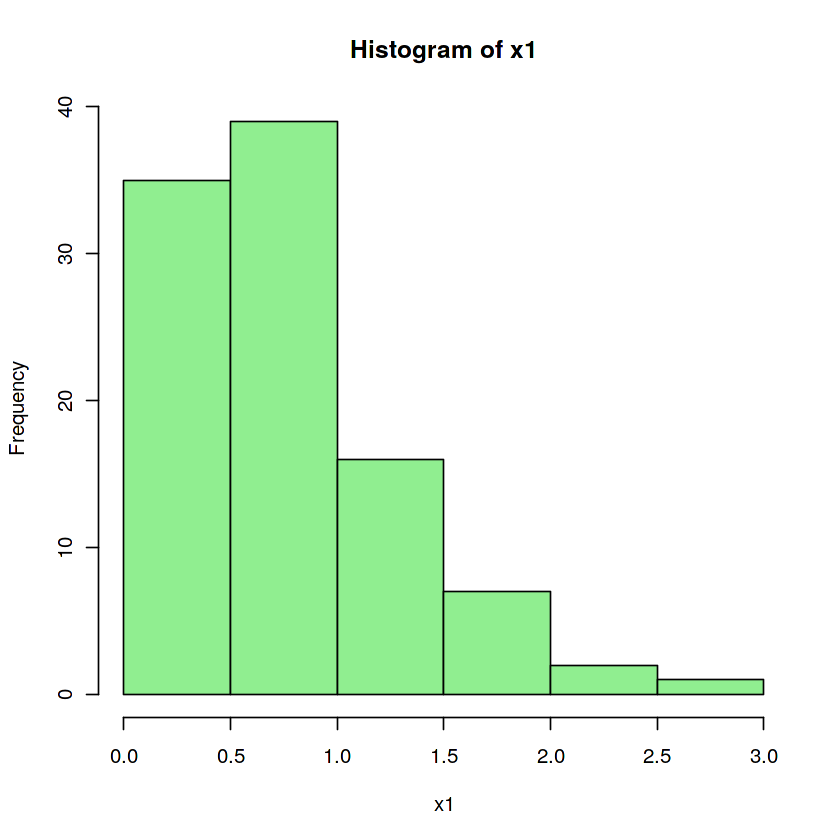

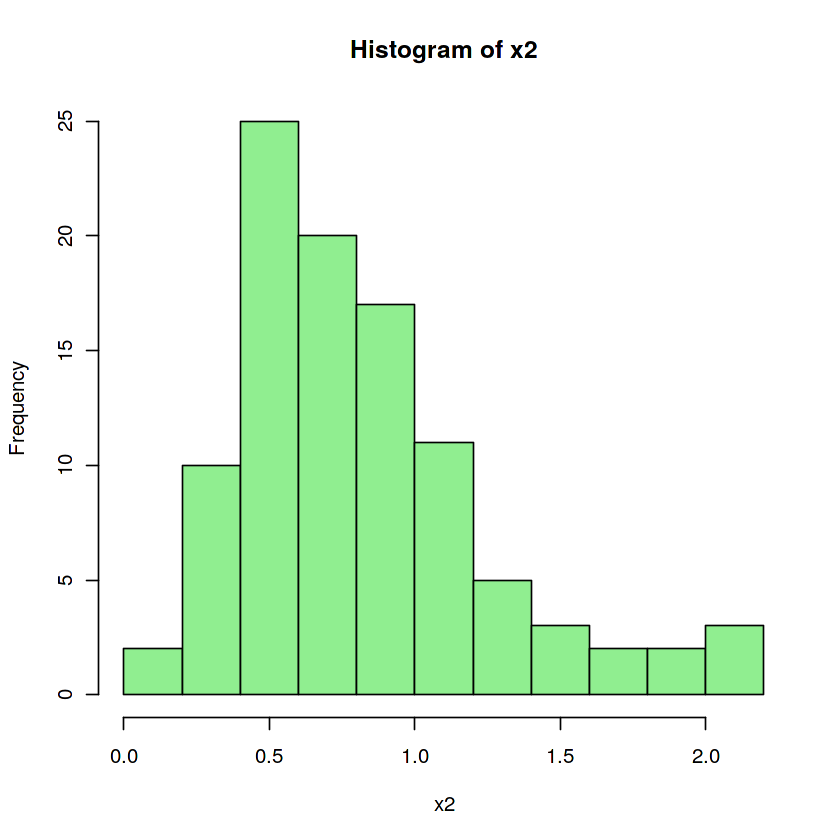

In [36]:
set.seed(1010)

x1 <- rgamma(100, shape = 3, rate = 4)
x2 <- rgamma(100, shape = 4, rate = 5)

hist(x1, col = "lightgreen")
hist(x2, col = "lightgreen")

In [37]:
## T TEST RESULT
t.test(x1, x2)


	Welch Two Sample t-test

data:  x1 and x2
t = -0.35664, df = 193.2, p-value = 0.7217
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.1509575  0.1047240
sample estimates:
mean of x mean of y 
0.7815999 0.8047166 


In [38]:
## Z TEST RESULT
dbar <- mean(x1) - mean(x2)
se   <- sqrt(var(x1) / length(x1) + var(x2) / length(x2))
z    <- dbar / se
z

[1] -0.3566434

In [39]:
pvalue <- 2 * (1 - pnorm(abs(z)))
pvalue

[1] 0.7213588

The $p$-values we get differ only on the $4$th decimal digit.

In [40]:
ci95 <- dbar + c(-1, 1) * se * qnorm(.975)
ci95

[1] -0.1501566  0.1039232

Confidence interval bounds also differ only on $4$th decimal digits.

We use a $t$ test with the correction for unequal variances. Usually in large samples it will not make any
visible difference. However, if corrected degrees of freedom are markedly reduced this may suggest
that the sample distributions may be very unbalanced with respect to variance and perhaps also sample sizes
and this may slow down the rate of convergence of CLT.

### $t$ test power analysis

Power calculations are always hard and usually analytically intractable.
That is why it is nice that base `R` provides us with a function for examining
power of $t$ tests.

We can use it in two different ways. Either to calculate minimum sample size
needed to gaurantee a given level of power conditioned on specific $\alpha$
and minimum effect of interest or to calculate power of a test with specific
alpha, minimum effect and sample size.

We will study the case of a difference between two samples
with two-sided $\alpha = 0.05$ and minimum detectable difference of $1$
with expected standard deviation of $2$. We will want to have power of $1 - \beta = 0.90$.

In [41]:
## CALCULATING MINIMUM REQUIRED SAMPLE SIZE
alpha <- 0.05    # significance level
delta <- 1
stdev <- 2
power <- 0.90

power.t.test(delta = delta, sd = stdev, sig.level = alpha, power = power, strict = TRUE)


     Two-sample t test power calculation 

              n = 85.03126
          delta = 1
             sd = 2
      sig.level = 0.05
          power = 0.9
    alternative = two.sided

NOTE: n is number in *each* group


Now we will consider a case in which we already collected data but want to estimate the power of our test.

In [42]:
n     <- 30
alpha <- 0.05
delta <- 1
stdev <- 2

power.t.test(n = n, delta = delta, sd = stdev, sig.level = alpha, strict = TRUE)


     Two-sample t test power calculation 

              n = 30
          delta = 1
             sd = 2
      sig.level = 0.05
          power = 0.4778965
    alternative = two.sided

NOTE: n is number in *each* group


Note how small is the power. This is an important point. Small sample sizes usually provides us with little
statistical power. This is why it is so important to remember that not rejecting $H_0$ does not necessarily mean
it is true. For the same reason, this is why it is almost always good to do power analysis when planning an experiment.
This way you may determine how many subjects do you need in order to give you a fighting chance for detecting an
effect you are interested in.

## COVID-19 | Growth rate analysis

Here we will try to do a simple analysis of data about COVID-19 cases. For simplicity we will limit our attention to cases in Poland.
We will focus on estimating the growth rate of the process, since this is one of the most important property of epidemic processes
such as the ongoing teribble pandemic.

Our analysis will be very simple, so we should not be to attached to the results we will produce. In particular, in this first approach
we will assume that the growth rate is stable in time, which is most probably untrue. However, we do not have proper tool to deal
with a trend yet, so we have to resort to such a simplifying assumption.

We will use a [dataset](https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv) with time series of COVID-19 cases by countries/regions compiled by John Hopkins University.

This analysis is based on the version of the file from 28.03.2020.

In [43]:
data <- read_csv("../data/time_series_covid19_confirmed_global.csv")
head(data)

Parsed with column specification:
cols(
  .default = col_double(),
  `Province/State` = col_character(),
  `Country/Region` = col_character()
)

See spec(...) for full column specifications.



Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,⋯,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NA,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,⋯,22,22,24,24,40,40,74,84,94,110
NA,Albania,41.1533,20.1683,0,0,0,0,0,0,⋯,59,64,70,76,89,104,123,146,174,186
NA,Algeria,28.0339,1.6596,0,0,0,0,0,0,⋯,74,87,90,139,201,230,264,302,367,409
NA,Andorra,42.5063,1.5218,0,0,0,0,0,0,⋯,39,53,75,88,113,133,164,188,224,267
NA,Angola,-11.2027,17.8739,0,0,0,0,0,0,⋯,0,0,1,2,2,3,3,3,4,4
NA,Antigua and Barbuda,17.0608,-61.7964,0,0,0,0,0,0,⋯,1,1,1,1,1,3,3,3,7,7


In [44]:
## GET DATA FOR POLAND
## DROP UNNESECCARY COLUMNS
## AND CAST TO LONG FORMAT
## AND LIMIT DATA TO DAYS WITH NON-ZERO NUMBER OF CASES
PL <- data %>%
    filter(`Country/Region` == "Poland") %>%
    select(-`Province/State`, -`Country/Region`, -Lat, -Long) %>%
    pivot_longer(everything(), names_to = "date", values_to = "cases") %>%
    filter(cases > 0) %>%
    mutate(date = fct_inorder(factor(date)))

PL

date,cases
<fct>,<dbl>
3/4/20,1
3/5/20,1
3/6/20,5
3/7/20,5
3/8/20,11
3/9/20,16
3/10/20,22
3/11/20,31
3/12/20,49


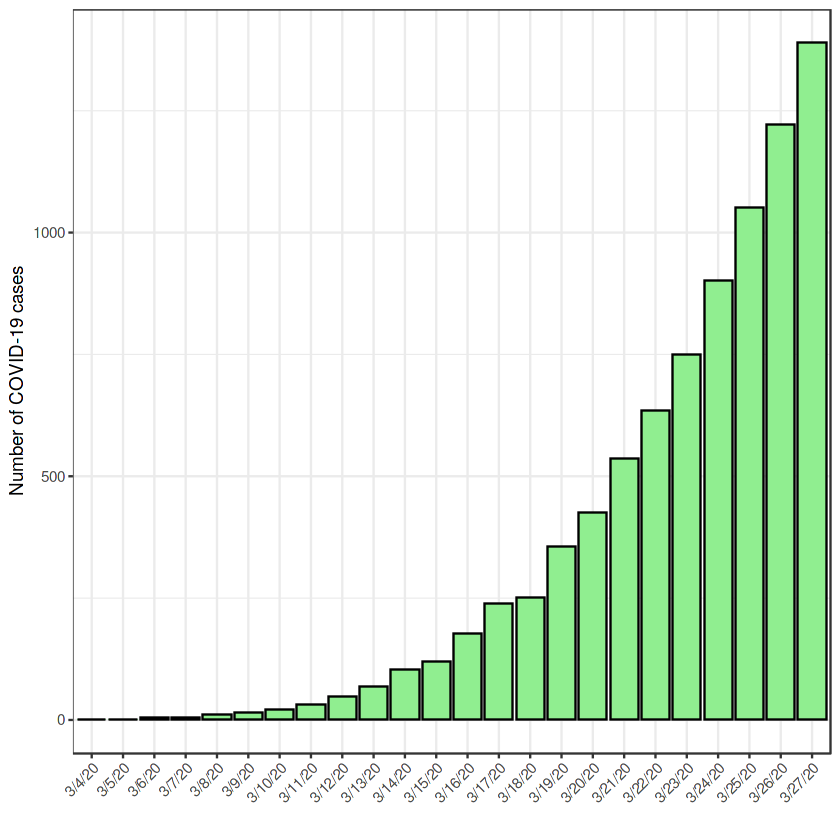

In [45]:
## CHECK DISTRIBUTION
PL %>%
    ggplot(aes(x = date, y = cases)) +
    geom_bar(color = "black", fill = "lightgreen", stat = "identity") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    xlab("") +
    ylab("Number of COVID-19 cases")

The distribution is clearly not normal and grows quasi-exponentially. But this is not a problem (in terms of statistics), since we are
not interested in raw numbers but rather in rate of growth. So we should rather look at ratios:
$$
\frac{x_{t+1}}{x_{t}}
$$

Warning message:
“Removed 1 rows containing missing values (position_stack).”


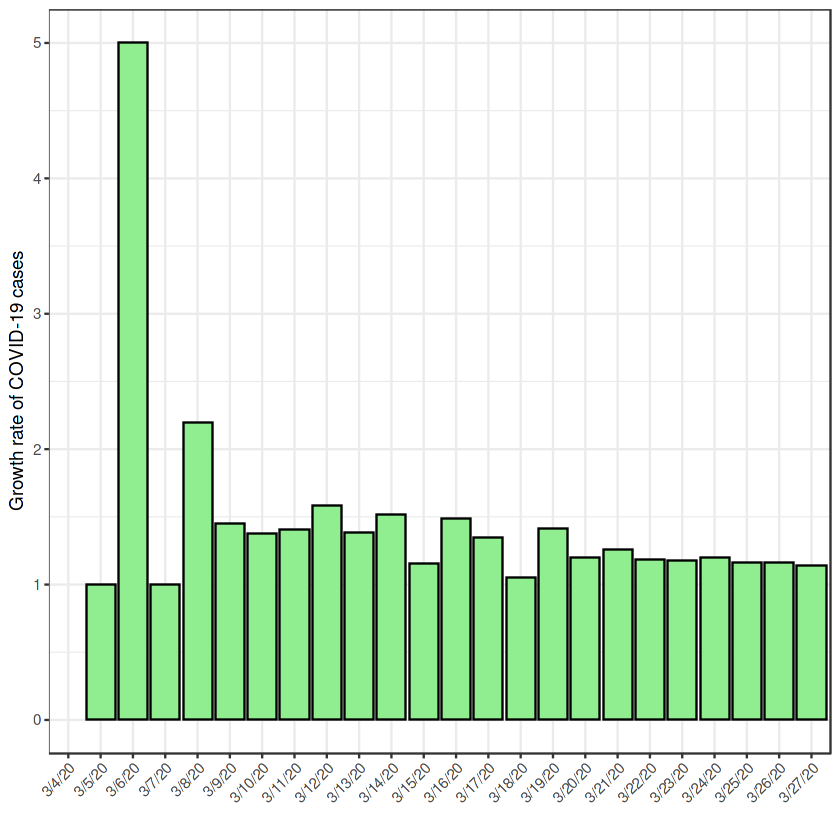

In [46]:
## COMPUTE RATIOS
## WE LOSE THE FIRST DATA POINT FOR WHICH WE CAN NOT COMPUTE RATIO
PL$ratio <- PL$cases / lag(PL$cases, k = 1)

## CHECK DISTRIBUTION
PL %>%
    ggplot(aes(x = date, y = ratio)) +
    geom_bar(color = "black", fill = "lightgreen", stat = "identity") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    xlab("") +
    ylab("Growth rate of COVID-19 cases")

Except for some spikes in the very beginning when there were just few cases the rate of growth seems to be relatively stable.
Thus, it is best to drop data for first five days as data for early day is likely to have been driven by a different data generating process.

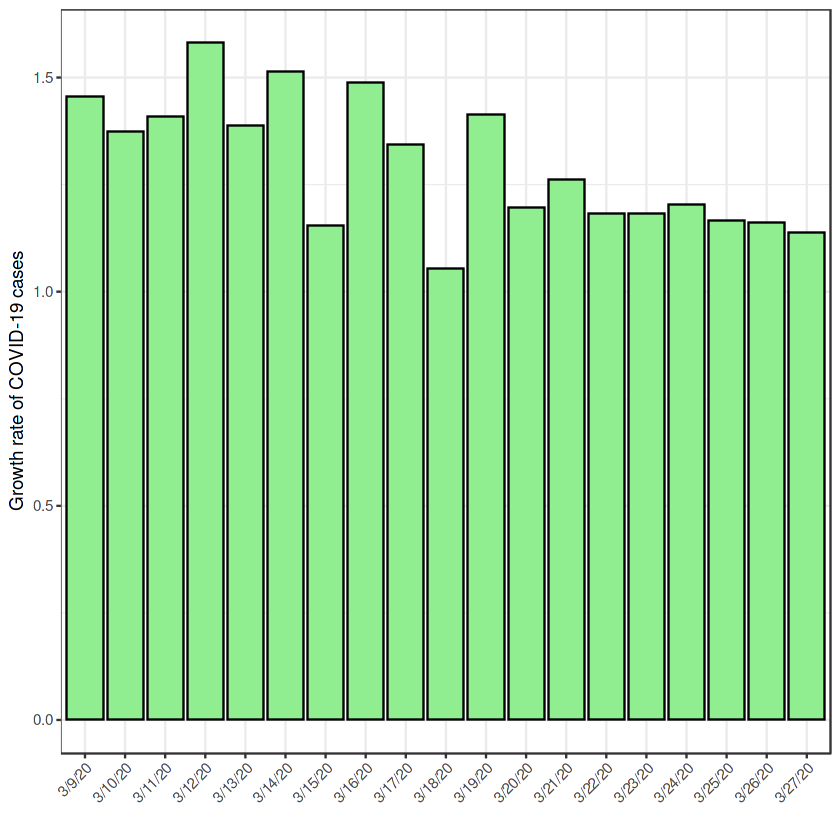

In [47]:
PL2 <- slice(PL, 6:nrow(PL))

## CHECK DISTRIBUTION
PL2 %>%
    ggplot(aes(x = date, y = ratio)) +
    geom_bar(color = "black", fill = "lightgreen", stat = "identity") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    xlab("") +
    ylab("Growth rate of COVID-19 cases")

This is a time series data, so before we can proceed further we should check whether we really assume that observations are independent.
To do this we can construct a plot of so-called autocorrelation function. It shows how much correlated are observations at time
$t$ with observations at time $t - k$ where $k$ is the number of time steps of difference usually called _lag_.

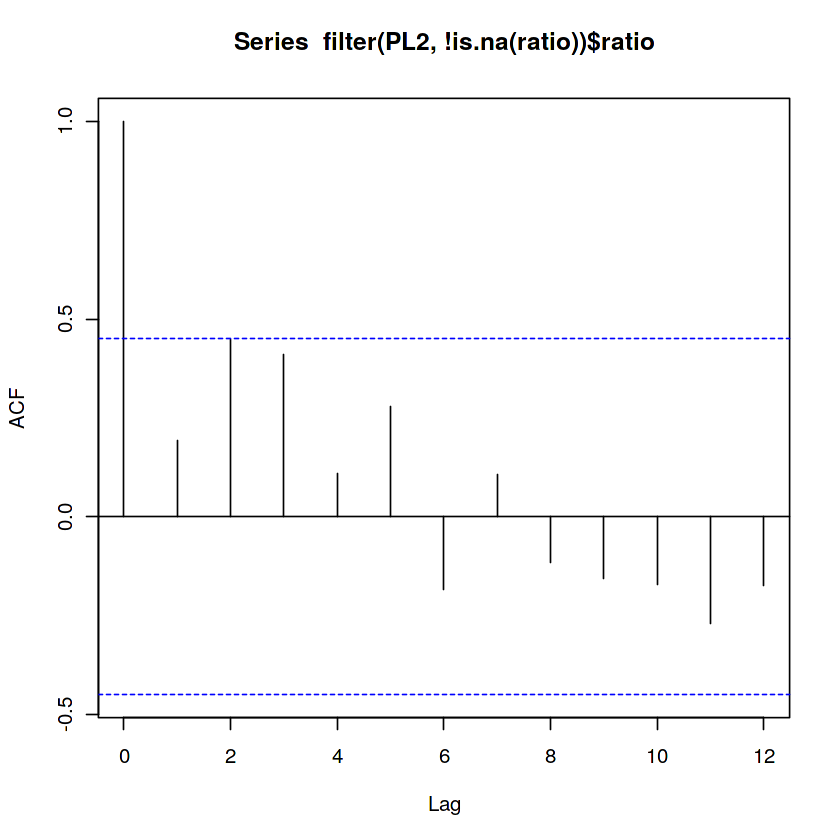

In [48]:
acf(filter(PL2, !is.na(ratio))$ratio)

The blue bands show the acceptable level of observed correlations under the assumption of now correlation in the data generating process.
So it seems we can safely assume that our observations of ratios are IID.

On the other hand the data does not look very ''normal'' and the sample is relatively small, so perhaps the best thing
we can do (although still rather inaccurate) is to use bootstrap.

More specifically, since we are interested in the growth rate we will estimate its expected value but also standard deviation to check
how volatile is the trend.

In [49]:
## LOAD `boot` LIBRARY FOR BOOTSTRAP ROUTINES
library(boot)

In [50]:
set.seed(303)
## FUNCTION COMPUTING MEAN AND STANDARD DEVIATION
statistic <- function(data, indexes) {
    boot_data <- data[indexes]
    c(
        xbar = mean(boot_data, na.rm = TRUE),
        s2   = var(boot_data, na.rm = TRUE)
    )
}

## BOOTSTRAP RESULT (10000 replicates)
result <- boot(PL2$ratio, statistic, R = 10000)
result


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = PL2$ratio, statistic = statistic, R = 10000)


Bootstrap Statistics :
      original       bias    std. error
t1* 1.29839051  0.000444795 0.034068487
t2* 0.02321415 -0.001241872 0.004793943

The boostrap distribution of average growth looks quite normal.

The expected growth rate is about $29.9\%$ a day.

Remember that in this analysis we assumed that the true growth rate of the data generating process is stable.
This is rather untrue, but given the distribution of growth ratios that we plotted it can be considered a rough approximation
to what is happening right now. Nonetheless, we should be rather cautious when interpreting our results.

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.177   1.275   1.299   1.299   1.322   1.413 

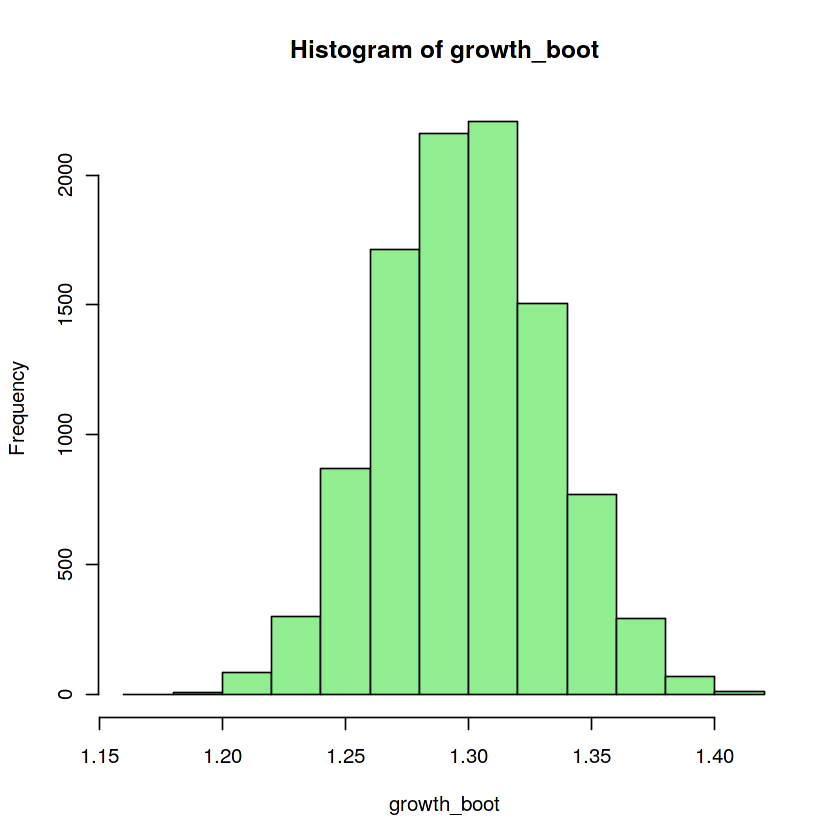

In [51]:
growth_boot <- result$t[, 1]
summary(growth_boot)

hist(growth_boot, col = "lightgreen")

In [52]:
## 95% PERCENTILE INTERVAL
print(quantile(growth_boot, probs = c(0.025, 0.975)))

    2.5%    97.5% 
1.232717 1.366860 


So our modest estimation suggests that true growth rate of the process may be somewhere in between $23.3\%$ and $36.7\%$.

We can also use our results to estimate the expected number of days in which the numebr of cases doubles.
To do this we have to solve the following equation:
$$
g^k = 2
$$
where $g$ is a growth rate.

To solve it we start by taking a natural logarithm of both sides, which yields:
$$
k\log{g} = \log{2}
$$
So:
$$
k = \frac{\log{2}}{\log{g}}
$$

Thus, using our the expected growth rate we get:
$$
k \approx 2.65\text{ days}
$$

The lower bound based on the $95\%$ two-sided percentile bootstrap confidence interval is:
$$
k_{\text{low}} \approx 3.31\text{ days}
$$

Both estimates are markedly lower from estimated growth rates based on slightly more advanced models such as those given
on an excellent blog [Fizyk Wyjaśnia](http://www.fizykwyjasnia.pl/na-biezaco/prognozy-rozwoju-epidemii-koronawirusa/)
(unfortunatelly it is only in Polish).

Next time, once we learn some more statistics, we will try to do better.

The reason our analysis is not very accurate is the fact that we did not take into account a decreasing trend of growth rates in time.
We can see it on a plot.

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 1 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


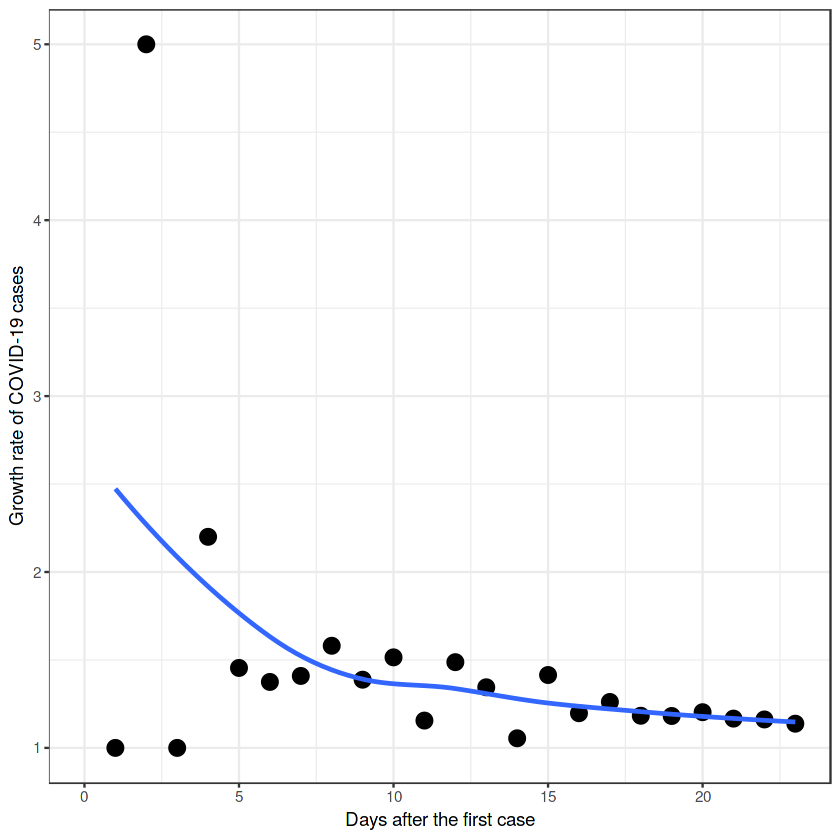

In [53]:
PL %>%
    ggplot(aes(x = seq_along(ratio)-1, y = ratio)) +
    geom_point(size = 4) +
    geom_smooth(method = "loess", se = FALSE) +
    xlab("Days after the first case") +
    ylab("Growth rate of COVID-19 cases")

## Exercise

Try to do a similar analysis for some other countries. Remember to consider how likely is the assumption of growth rate stability in time. 